# 0. Importing the Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast

# 1. Downloading the Datasets

In [2]:
product_catalog = pd.read_csv("original_data/product_catalog.csv")
product_category = pd.read_csv("original_data/product_category_map.csv")
transactions = pd.read_csv("original_data/transactions.csv")
test = pd.read_csv("original_data/test.csv")

## 1a. Analyzing & Preprocessing the Dataset

Investigating the entities, dtypes, numeric information etc.

### <center> - Product Catalog DataFrame - </center>

In [3]:
product_catalog.head()

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,28640,1366,10,1,537,0,101,NaN
2,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
3,21399,1090,10,1,511,0,0,[3270]
4,8504,768,4,1,484,0,66,[2470]


In [4]:
product_catalog.describe()

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5
count,32776.000000,32776.000000,32776.000000,32776.000000,32776.000000,32776.000000,32776.000000
mean,16387.500000,702.776574,6.451062,0.817946,440.280388,0.804735,74.689285
std,9461.760548,432.774074,2.744884,0.778284,132.566994,1.354669,57.621143
min,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,8193.750000,322.000000,4.000000,0.000000,453.000000,0.000000,17.000000
50%,16387.500000,648.000000,6.000000,1.000000,491.000000,0.000000,66.000000
75%,24581.250000,1073.000000,10.000000,1.000000,509.000000,3.000000,126.000000
max,32775.000000,1513.000000,10.000000,3.000000,538.000000,4.000000,190.000000


In [5]:
product_catalog.isna().sum()

product_id            0
manufacturer_id       0
attribute_1           0
attribute_2           0
attribute_3           0
attribute_4           0
attribute_5           0
categories         6788
dtype: int64

In [6]:
product_catalog.shape

(32776, 8)

In [7]:
product_catalog.dtypes

product_id          int64
manufacturer_id     int64
attribute_1         int64
attribute_2         int64
attribute_3         int64
attribute_4         int64
attribute_5         int64
categories         object
dtype: object

In [8]:
product_catalog["categories"].nunique()

12191

In [9]:
product_catalog["categories"] = product_catalog['categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() != '' else [])

In [10]:
unique_categories = list()
for row in product_catalog["categories"]:
    for entity in row:
        if entity not in unique_categories:
            unique_categories.append(entity)

len(unique_categories)

3360

In [11]:
filtered_product_catalog = product_catalog[product_catalog['categories'].map(len) > 0].reset_index(drop=True)
display(filtered_product_catalog)



,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
2,21399,1090,10,1,511,0,0,[3270]
3,8504,768,4,1,484,0,66,[2470]
4,31956,1388,4,0,491,0,66,"[236, 3625, 356]"
...,...,...,...,...,...,...,...,...
25983,12036,1383,10,0,503,0,101,"[3502, 1088, 2004, 691, 3422, 2308, 308, 3688,..."
25984,22709,567,4,2,491,3,66,"[3900, 3905, 3903, 3910, 1807, 274, 1467, 914]"
25985,32322,1385,10,1,500,0,37,"[2686, 2609, 725]"
25986,19118,1113,6,2,491,0,117,"[3900, 3910, 3903, 2473, 914, 274]"


In [12]:
import numpy as np
from collections import deque

class DBSCAN:
    def __init__(self, rate=0.7, min_samples=2):
        self.rate = rate
        self.min_samples = min_samples
        self.labels_ = None

    def calculate_match_rate(self, x1, x2):
        ortak = 0
        for i in x1:
            if i in x2:
                ortak += 1
        if len(x1) == 0 and len(x2) == 0:
            return 0
        return ortak / (len(x1) + len(x2) - ortak)

    def fit(self, X):
        # Get number of points
        n_points = X.shape[0]

        # Initialize all labels as -1 (unclassified)
        self.labels_ = np.full(shape=n_points, fill_value=-1)

        cluster_id = 0

        # Arbitrary select a point p
        for i in range(n_points):

            if i % 25 == 0:
                print(f"Processing point {i}...")

            # Already classified
            if self.labels_[i] != -1:
                continue

            # Retrieve all points density-reachable from p wrt Eps and MinPts
            neighbors = self._region_query(X, i)

            # If p has not enough points which are density-reachable from p and DBSCAN visits the next point of the database
            if len(neighbors) < self.min_samples:
                self.labels_[i] = -1
            else:
                # If p is a core point, a cluster is formed
                self._expand_cluster(X, i, neighbors, cluster_id)
                cluster_id += 1

    def _region_query(self, X, point_idx):
        neighbors = []

        # Get distance with every other point and compare with eps
        for i in range(X.shape[0]):

            if self.calculate_match_rate(X[i], X[point_idx]) > self.rate:
                neighbors.append(i)

        return neighbors

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id):
        # Assign the cluster label
        self.labels_[point_idx] = cluster_id

        # Turn list of neighbors to queue
        queue = deque(neighbors)

        while queue:

            # Get a neighbor
            neighbor_idx = queue.popleft()

            # Previously marked as noise
            if self.labels_[neighbor_idx] == -1:
                self.labels_[neighbor_idx] = cluster_id
            elif self.labels_[neighbor_idx] != -1:
                continue

            new_neighbors = self._region_query(X, neighbor_idx)

            if len(new_neighbors) >= self.min_samples:
                queue.extend(new_neighbors)

In [13]:
DBSCAN = DBSCAN(rate=0.6, min_samples=2)
DBSCAN.fit(filtered_product_catalog["categories"])

filtered_product_catalog["cluster"] = DBSCAN.labels_

Processing point 0...
Processing point 25...
Processing point 50...
Processing point 75...
Processing point 100...
Processing point 125...
Processing point 150...
Processing point 175...
Processing point 200...
Processing point 225...
Processing point 250...
Processing point 275...
Processing point 300...
Processing point 325...
Processing point 350...
Processing point 375...
Processing point 400...
Processing point 425...
Processing point 450...
Processing point 475...
Processing point 500...
Processing point 525...
Processing point 550...
Processing point 575...
Processing point 600...
Processing point 625...
Processing point 650...
Processing point 675...
Processing point 700...
Processing point 725...
Processing point 750...
Processing point 775...
Processing point 800...
Processing point 825...
Processing point 850...
Processing point 875...
Processing point 900...
Processing point 925...
Processing point 950...
Processing point 975...
Processing point 1000...
Processing point 102

In [38]:
num_clusters = filtered_product_catalog['cluster'].nunique()
print(f'The number of distinct clusters is: {num_clusters}')

The number of distinct clusters is: 2330


In [41]:
cluster_1_elements = filtered_product_catalog[filtered_product_catalog['cluster'] == 3]
display(cluster_1_elements)

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,cluster
4,31956,1388,4,0,491,0,66,"[236, 3625, 356]",3
671,19896,408,4,0,284,0,66,"[236, 356]",3
1537,27494,147,4,0,490,3,66,"[1524, 236, 3625, 356]",3
1658,25132,1144,4,1,283,0,44,"[236, 3625, 356]",3
2306,449,1115,6,1,490,0,-1,"[236, 3625, 356]",3
3213,7765,701,4,1,283,0,53,"[236, 356]",3
4735,9990,411,4,1,491,3,66,"[236, 356]",3
4822,31762,110,4,1,535,3,140,"[236, 356]",3
4829,20752,110,4,0,535,3,140,"[236, 356]",3
5246,13815,388,4,0,491,0,66,"[236, 3625, 356]",3


### <center> - Product Category - </center>

In [14]:
product_category.head()

,category_id,parent_category_id
0,0,75
1,1,1499
2,2,1082
3,3,3498
4,4,1623


In [15]:
product_category.describe()

,category_id,parent_category_id
count,4332.000000,4332.000000
mean,2147.165512,2204.845568
std,1241.039814,1222.376330
min,0.000000,8.000000
25%,1069.750000,1143.750000
50%,2146.500000,2284.000000
75%,3221.250000,3329.000000
max,4299.000000,3898.000000


In [16]:
product_category.isna().sum()

category_id           0
parent_category_id    0
dtype: int64

In [17]:
product_category.dtypes

category_id           int64
parent_category_id    int64
dtype: object

In [18]:
product_catalog

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,28640,1366,10,1,537,0,101,[]
2,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
3,21399,1090,10,1,511,0,0,[3270]
4,8504,768,4,1,484,0,66,[2470]
...,...,...,...,...,...,...,...,...
32771,12036,1383,10,0,503,0,101,"[3502, 1088, 2004, 691, 3422, 2308, 308, 3688,..."
32772,22709,567,4,2,491,3,66,"[3900, 3905, 3903, 3910, 1807, 274, 1467, 914]"
32773,32322,1385,10,1,500,0,37,"[2686, 2609, 725]"
32774,19118,1113,6,2,491,0,117,"[3900, 3910, 3903, 2473, 914, 274]"


### <center> - Transactions - </center>

In [19]:
transactions.head()

,customer_id,product_id,purchase_date,quantity
0,38769,3477,2020-06-01,1
1,42535,30474,2020-06-01,1
2,42535,15833,2020-06-01,1
3,42535,20131,2020-06-01,1
4,42535,4325,2020-06-01,1


In [20]:
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

In [21]:
transactions.head()

,customer_id,product_id,purchase_date,quantity
0,38769,3477,2020-06-01,1
1,42535,30474,2020-06-01,1
2,42535,15833,2020-06-01,1
3,42535,20131,2020-06-01,1
4,42535,4325,2020-06-01,1


In [22]:
transactions.describe()

,customer_id,product_id,purchase_date,quantity
count,1.071538e+06,1.071538e+06,1071538,1.071538e+06
mean,2.307968e+04,1.652196e+04,2020-10-05 06:54:07.242748672,1.399758e+00
min,0.000000e+00,0.000000e+00,2020-06-01 00:00:00,1.000000e+00
25%,1.152400e+04,8.350000e+03,2020-08-03 00:00:00,1.000000e+00
50%,2.310300e+04,1.696000e+04,2020-10-07 00:00:00,1.000000e+00
75%,3.465500e+04,2.457900e+04,2020-12-08 00:00:00,1.000000e+00
max,4.613700e+04,3.277500e+04,2021-01-31 00:00:00,1.000000e+02
std,1.331930e+04,9.451299e+03,NaN,1.479233e+00


In [23]:
transactions.isna().sum()

customer_id      0
product_id       0
purchase_date    0
quantity         0
dtype: int64

In [24]:
transactions.dtypes

customer_id               int64
product_id                int64
purchase_date    datetime64[ns]
quantity                  int64
dtype: object

In [25]:
# Sort by customer_id, product_id, and purchase_date
transactions = transactions.sort_values(by=['customer_id', 'product_id', 'purchase_date'])

In [26]:
transactions.head()

,customer_id,product_id,purchase_date,quantity
390966,0,1505,2020-09-01,1
819667,0,6446,2020-12-11,1
978365,0,6446,2021-01-15,1
709719,0,9325,2020-11-20,1
268197,0,12468,2020-08-03,1


In [27]:
transactions['next_purchase_date'] = transactions.groupby(['customer_id', 'product_id'])['purchase_date'].shift(-1)
display(transactions)

,customer_id,product_id,purchase_date,quantity,next_purchase_date
390966,0,1505,2020-09-01,1,NaT
819667,0,6446,2020-12-11,1,2021-01-15
978365,0,6446,2021-01-15,1,NaT
709719,0,9325,2020-11-20,1,NaT
268197,0,12468,2020-08-03,1,NaT
...,...,...,...,...,...
995072,46137,22403,2021-01-18,1,NaT
1069936,46137,22583,2021-01-31,1,NaT
287156,46137,28343,2020-08-08,1,NaT
287097,46137,28900,2020-08-08,2,NaT


In [28]:
transactions['re_purchased_week'] = (1+(transactions['next_purchase_date'] - transactions['purchase_date']).dt.days / 7).fillna(0).astype(int)
transactions.head()

,customer_id,product_id,purchase_date,quantity,next_purchase_date,re_purchased_week
390966,0,1505,2020-09-01,1,NaT,0
819667,0,6446,2020-12-11,1,2021-01-15,6
978365,0,6446,2021-01-15,1,NaT,0
709719,0,9325,2020-11-20,1,NaT,0
268197,0,12468,2020-08-03,1,NaT,0


In [29]:
new_df = transactions.drop(columns=['purchase_date', 'next_purchase_date'])
new_df.head()

,customer_id,product_id,quantity,re_purchased_week
390966,0,1505,1,0
819667,0,6446,1,6
978365,0,6446,1,0
709719,0,9325,1,0
268197,0,12468,1,0


In [30]:
new_df[new_df["quantity"] == 1].re_purchased_week.unique()

array([ 0,  6, 19, 10,  4,  7,  3, 13, 18, 17,  9,  8, 11, 30, 27,  5, 12,
       23, 29, 16, 21, 15, 22, 24, 20,  2, 32,  1, 26, 25, 14, 31, 28, 33,
       35, 34])

In [31]:
# Counting the occurrences of each re_purchased_week value
counts = new_df['re_purchased_week'].value_counts()

# Creating a new DataFrame to include weeks from 0 to 4
re_purchased_df = pd.DataFrame({'re_purchased_week': range(6), 'count': 0})
re_purchased_df.set_index('re_purchased_week', inplace=True)

# Updating the counts for weeks that exist in the data
for week, count in counts.items():
    if week in re_purchased_df.index:
        re_purchased_df.at[week, 'count'] = count

    elif week > 5:
        re_purchased_df.at[5, 'count'] += count

# Calculating the percentages
total_counts = re_purchased_df['count'].sum()
re_purchased_df['percentage'] = (re_purchased_df['count'] / total_counts * 100).round(2)

# Resetting index to make it more readable
final_df = re_purchased_df.reset_index()
final_df


,re_purchased_week,count,percentage
0,0,896426,83.66
1,1,3519,0.33
2,2,4974,0.46
3,3,7641,0.71
4,4,10279,0.96
5,5,148699,13.88


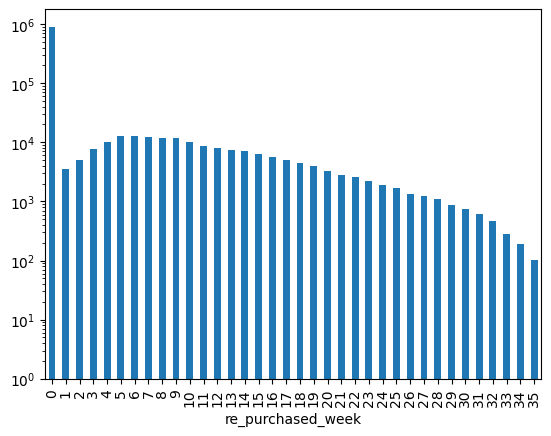

In [32]:
transactions["re_purchased_week"].value_counts().sort_index().plot(kind="bar", log=True);

In [33]:
final_df.describe()

,re_purchased_week,count,percentage
count,6.000000,6.000000,6.000000
mean,2.500000,178589.666667,16.666667
std,1.870829,356237.706762,33.246743
min,0.000000,3519.000000,0.330000
25%,1.250000,5640.750000,0.522500
50%,2.500000,8960.000000,0.835000
75%,3.750000,114094.000000,10.650000
max,5.000000,896426.000000,83.660000


#### <center> PCA </center>

In [34]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# I am not sure if these are the "most optimal" measures. We need to do experiment on that. (GBD)
customer_features = new_df.groupby('customer_id').agg({
    'product_id': 'nunique',
    'quantity': 'mean',         # Average of the purchased quantity
    're_purchased_week': 'mean' # Average repurchase interval
}).reset_index()

# Normalizing the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.iloc[:, 1:])

# Determining optimal k using Silhouette Score
sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(normalized_features)
    sil_scores.append(silhouette_score(normalized_features, labels))

optimal_k = sil_scores.index(max(sil_scores)) + 2

# Final clustering with optimal k value
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(normalized_features)

# Saving results
customer_features.to_csv('clustered_customers.csv', index=False)


In [35]:
customer_features.nunique()

customer_id          46138
product_id             100
quantity              2218
re_purchased_week     4747
Cluster                  5
dtype: int64

In [36]:
max(sil_scores)

np.float64(0.38759330741247605)

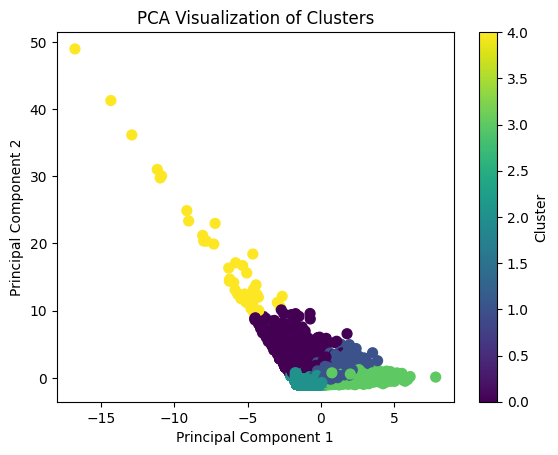

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

# Visalizing the clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=customer_features['Cluster'], cmap='viridis', s=50)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()
